# Clasificador de Imágenes con Pytorch: Piezas de ajedrez

**Autores:** Luna Yue Hernández Guerra y Kimberly Casimiro Torres

## 1. Introducción
El objetivo de esta práctica es desarrollar un clasificador de imágenes en Pytorch, utilizando redes convolucionales, de piezas de ajedrez utilizando una red convolucional con PyTorch. Este modelo se entrenará para reconocer diferentes tipos de piezas, como el alfil, rey, caballo, entre otros.

## 2. Métodos y Conjuntos de Datos
### 2.1 Métodos

### 2.2 Dataset
Para llevar a cabo el clasificador, debemos buscar un conjunto de datos con el cual probarlo. En este caso, hemos escogido un dataset de imágenes de piezas de ajedrez. Dicho dataset se puede obtener en [Kaggle](https://www.kaggle.com/datasets/niteshfre/chessman-image-dataset). Su contenido consta de 6 subdirectorios que representan las distintas clases: alfil, rey, caballo, peón, dama y torre. Cada clase contiene entre 75 y 106 imágenes distintas entre sí, con diferentes colores, formas y posiciones.

Para reproducir este experimento, es necesario guardar dicho dataset en la ruta `data/raw`. Asimismo, se debe crear otro directorio `data/processed` para guardar con conjuntos de datos modificados durante el desarrollo del estudio, resultando la siguiente estructura de directorios:

```bash
data/
└── raw/
    └── Chess/
        ├── Bishop/
        ├── King/
        ├── Knight/
        ├── Pawn/
        ├── Queen/
        └── Rook/
└── processed/
```



## Experimentos y Resultados

Importamos las librerías que vamos a utilizar:

In [1]:
import os
from pathlib import Path
import shutil

import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets

c:\Users\chess\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


En primer lugar, vamos a utilizar la librería `optuna` para realizar una búsqueda automatizada de los mejores hiperparámetros. La red cuenta con 3 capas convolutivas, 1 capa de pooling, 2 capas fully-connected y dropout. Los hiperparámetros a estudiar son:
- Tamaño del batch (`batch_size`): Valores explorados: 16, 32, 64 y 128.
- Tasa de aprendizaje o learning rate (`lr`): Explorada en un rango logarítmico entre $10^{-5}$ y $10^{-1}$
- Tasa de dropout (`dropout_rate`): Explorada entre 0.1 y 0.5.

Además, a los datos originales divididos en entrenamiento (80%) y prueba/validación (20%), les aplicamos transformaciones de reescalado, conversión a tensores y normalización de los canales RGB. Aparte, a los datos de entrenamiento se les aplican técnicas de aumento de datos (data augmentation) como inversiones horizontales, rotaciones y ajustes de brillo, contraste y saturación.

In [2]:
def objective(trial):
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    data_path = 'data/raw/Chess'    

    transform_train = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    transform_test = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    full_data = datasets.ImageFolder(root=data_path, transform=transform_train)
    train_size = int(0.8 * len(full_data))
    test_size = len(full_data) - train_size
    train_data, test_data = random_split(full_data, [train_size, test_size])

    test_data.dataset.transform = transform_test

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    class ConvNet(nn.Module):
        def __init__(self, num_classes, dropout_rate):
            super(ConvNet, self).__init__()
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
            self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
            self.fc1 = nn.Linear(128 * 8 * 8, 256)
            self.dropout = nn.Dropout(dropout_rate)
            self.fc2 = nn.Linear(256, num_classes)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            x = torch.flatten(x, 1)
            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.fc2(x)
            return x

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    num_classes = len(full_data.classes)
    model = ConvNet(num_classes=num_classes, dropout_rate=dropout_rate).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    epochs = 5
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    return test_accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_params)

[I 2024-12-09 12:39:33,764] A new study created in memory with name: no-name-383a915e-4fbf-4099-a2f8-db60044fd418
[I 2024-12-09 12:40:10,721] Trial 0 finished with value: 14.414414414414415 and parameters: {'batch_size': 128, 'lr': 0.010636880431611135, 'dropout_rate': 0.28383255695677145}. Best is trial 0 with value: 14.414414414414415.
[I 2024-12-09 12:40:43,709] Trial 1 finished with value: 16.216216216216218 and parameters: {'batch_size': 16, 'lr': 0.007149547901345417, 'dropout_rate': 0.33809913389480406}. Best is trial 1 with value: 16.216216216216218.
[I 2024-12-09 12:41:11,657] Trial 2 finished with value: 24.324324324324323 and parameters: {'batch_size': 32, 'lr': 0.00020676511131331968, 'dropout_rate': 0.4892668129096859}. Best is trial 2 with value: 24.324324324324323.
[I 2024-12-09 12:41:38,552] Trial 3 finished with value: 28.82882882882883 and parameters: {'batch_size': 32, 'lr': 0.0008044719924919708, 'dropout_rate': 0.24440489180301933}. Best is trial 3 with value: 28.8

Best hyperparameters: {'batch_size': 32, 'lr': 0.0015195078076564678, 'dropout_rate': 0.17666674974837882}


Creamos un clasificador básico usando los datos originales.

In [3]:
# Definimos las transformaciones para normalizar los datos
transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Ruta de las imágenes
data_path = 'data/raw/Chess'

# Cargamos todas las imágenes de la carpeta con ImageFolder
full_data = datasets.ImageFolder(root=data_path, transform=transform)

# Dividimos en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(full_data))  # 80% para entrenamiento
test_size = len(full_data) - train_size  # 20% para prueba

train_data, test_data = random_split(full_data, [train_size, test_size])

# DataLoaders para el conjunto de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)


In [4]:
class ConvNet(nn.Module):
    def __init__(self, classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, len(classes))
        self.classes = classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class ConvNet2(nn.Module):
    def __init__(self, classes):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, len(classes))
        self.classes = classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        #print(x.shape)
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class ConvNet3(nn.Module):
    def __init__(self, classes):
        super(ConvNet3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(1024 * 1*1, 2048)
        self.fc2 = nn.Linear(2048, len(classes))
        self.classes = classes

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        #print(x.shape)
        x = x.view(-1, 1024 * 1*1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [5]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):
        """
        Inicializa el criterio para la parada temprana.
        
        Args:
            tolerance (int): Número de épocas sin mejora para detener el entrenamiento.
            min_delta (float): La mínima mejora que se necesita en la pérdida de validación.
        """
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False
        self.best_val_loss = float('inf')

    def __call__(self, validation_loss):
        """
        Llama a la función con la pérdida de entrenamiento y de validación.
        
        Args:
            train_loss (float): La pérdida en el conjunto de entrenamiento.
            validation_loss (float): La pérdida en el conjunto de validación.
        """
        if (self.best_val_loss - validation_loss) > self.min_delta:
            self.counter = 0  
            self.best_val_loss = validation_loss
        else:
            self.counter += 1 
        
        if self.counter >= self.tolerance:
            self.early_stop = True
            print("Parada temprana activada. No hay mejora en la pérdida de validación.")

In [6]:
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_train_loss, accuracy

def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.numpy())

            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    return avg_test_loss, accuracy, all_labels, all_preds

def plot_metrics(epochs_trained, train_losses, test_losses, train_accuracies, test_accuracies, all_labels, all_preds, classes):
    """
    Genera gráficas de las métricas: pérdida y precisión, además de la matriz de confusión.
    """
    # Gráfico de pérdidas
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs_trained + 1), train_losses[:epochs_trained], label="Training Loss")
    plt.plot(range(1, epochs_trained + 1), test_losses[:epochs_trained], label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Test Loss")
    plt.legend()

    # Gráfico de precisión
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs_trained + 1), train_accuracies[:epochs_trained], label="Training Accuracy")
    plt.plot(range(1, epochs_trained + 1), test_accuracies[:epochs_trained], label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Test Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Crear y graficar la matriz de confusión
    confusion_matrix = np.zeros((len(classes), len(classes)), dtype=int)
    for true_label, pred_label in zip(all_labels, all_preds):
        confusion_matrix[true_label, pred_label] += 1

    fig, ax = plt.subplots(figsize=(8, 8))
    cax = ax.matshow(confusion_matrix, cmap='Blues')
    plt.colorbar(cax)
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_yticklabels(classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, confusion_matrix[i, j], ha="center", va="center", color="black")

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

def train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs, start_early_stop=1):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    epochs_trained = 0

    for epoch in range(epochs):
        # Entrenamiento por una época
        train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch + 1}, Training Loss: {train_loss}, Training Accuracy: {train_accuracy}%")

        # Evaluación en el conjunto de prueba
        test_loss, test_accuracy, all_labels, all_preds = evaluate(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        print(f"Epoch {epoch + 1}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}%")

        # Early stopping
        if early_stopping:
            early_stopping(test_loss)
            if early_stopping.early_stop and epoch>start_early_stop:
                print(f"Entrenamiento detenido en la época {epoch + 1} debido a la parada temprana.")
                epochs_trained = epoch + 1
                break
    else:
        epochs_trained = epochs

    # Graficar resultados
    plot_metrics(epochs_trained, train_losses, test_losses, train_accuracies, test_accuracies, all_labels, all_preds, model.classes)
    return model

Clasificador básico:

(Sin parada temprana)

Epoch 1, Training Loss: 1.810154425246375, Training Accuracy: 18.594104308390023%
Epoch 1, Test Loss: 1.7928618362971716, Test Accuracy: 17.117117117117118%
Epoch 2, Training Loss: 1.7475942415850503, Training Accuracy: 23.12925170068027%
Epoch 2, Test Loss: 1.8014148133141654, Test Accuracy: 17.117117117117118%
Epoch 3, Training Loss: 1.6804646466459547, Training Accuracy: 28.34467120181406%
Epoch 3, Test Loss: 1.757974079677037, Test Accuracy: 19.81981981981982%
Epoch 4, Training Loss: 1.5560594286237444, Training Accuracy: 36.734693877551024%
Epoch 4, Test Loss: 1.8114435161863054, Test Accuracy: 29.72972972972973%
Epoch 5, Training Loss: 1.3838225730827876, Training Accuracy: 50.34013605442177%
Epoch 5, Test Loss: 1.803271668297904, Test Accuracy: 31.53153153153153%
Epoch 6, Training Loss: 1.192716555935996, Training Accuracy: 57.82312925170068%
Epoch 6, Test Loss: 1.7355623074940272, Test Accuracy: 39.63963963963964%
Epoch 7, Training Loss: 0.9418501747506005, Training Accuracy: 6

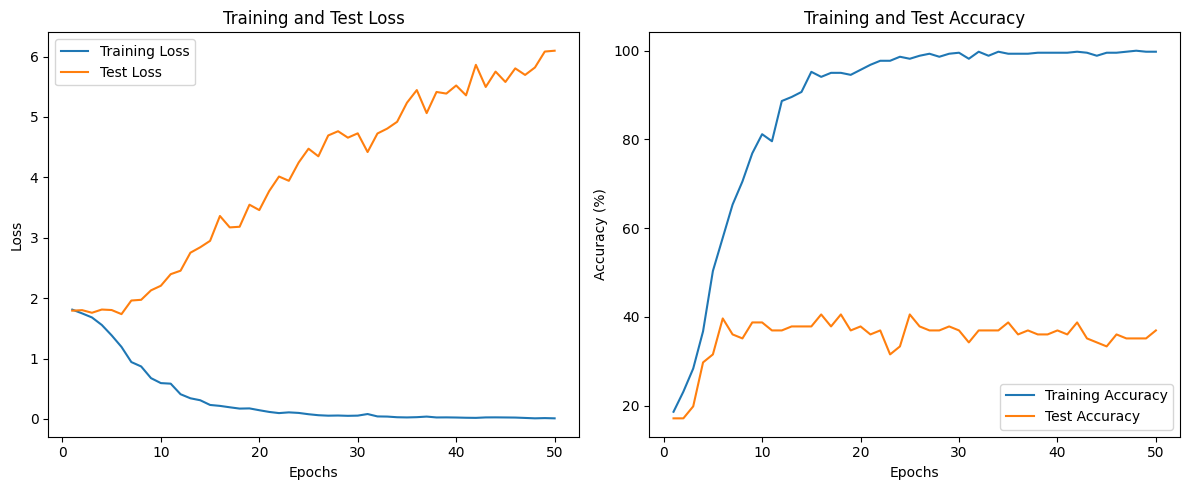

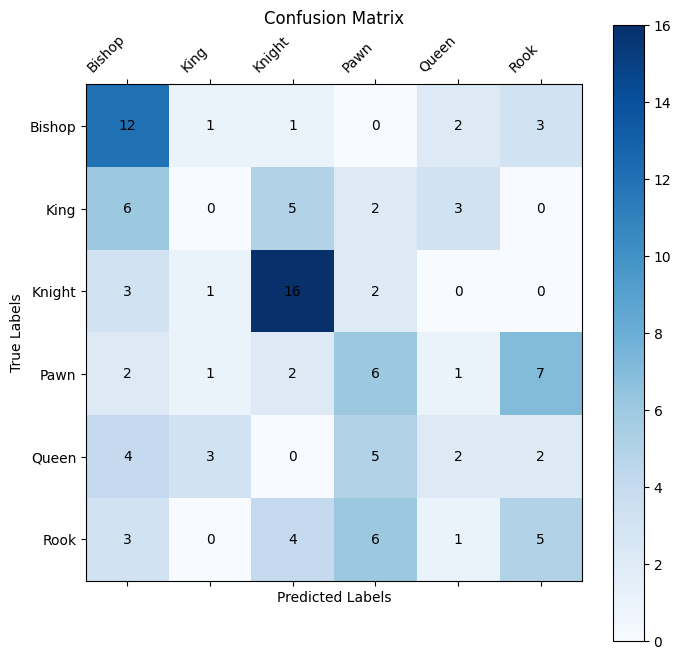

In [7]:
# Configuración inicial
model = ConvNet(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004)

# Entrenamiento
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, [], epochs=50)

(Con parada temprana)

Epoch 1, Training Loss: 1.7915654863630022, Training Accuracy: 19.27437641723356%
Epoch 1, Test Loss: 1.7941124609538488, Test Accuracy: 14.414414414414415%
Epoch 2, Training Loss: 1.7384553849697113, Training Accuracy: 23.582766439909296%
Epoch 2, Test Loss: 1.7645467690059118, Test Accuracy: 16.216216216216218%
Epoch 3, Training Loss: 1.6390355314527238, Training Accuracy: 33.333333333333336%
Epoch 3, Test Loss: 1.7598404032843453, Test Accuracy: 24.324324324324323%
Epoch 4, Training Loss: 1.4697087151663644, Training Accuracy: 45.57823129251701%
Epoch 4, Test Loss: 1.7108407361166817, Test Accuracy: 30.63063063063063%
Epoch 5, Training Loss: 1.2816837195839201, Training Accuracy: 51.24716553287982%
Epoch 5, Test Loss: 1.7073826960154943, Test Accuracy: 38.73873873873874%
Epoch 6, Training Loss: 1.0935043799025672, Training Accuracy: 61.904761904761905%
Epoch 6, Test Loss: 1.8926029205322266, Test Accuracy: 34.234234234234236%
Epoch 7, Training Loss: 0.9251508968217033, Training Accu

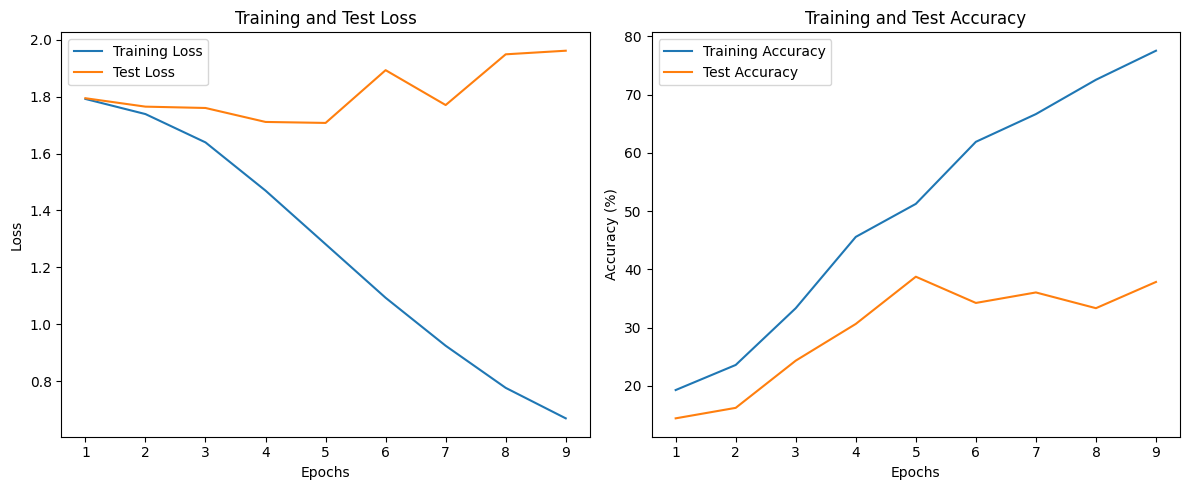

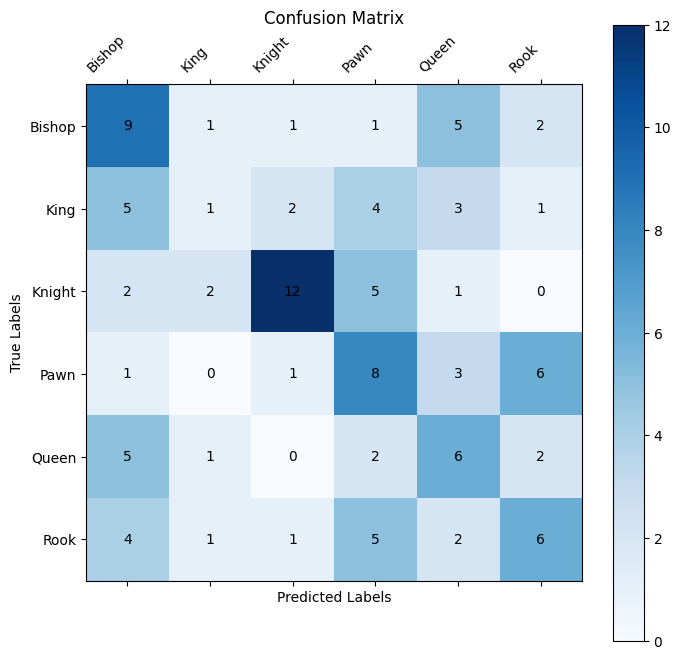

In [8]:
model = ConvNet(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50)


Usando 4 capas convolutivas

Epoch 1, Training Loss: 1.7869435463632857, Training Accuracy: 17.233560090702948%
Epoch 1, Test Loss: 1.7903089353016444, Test Accuracy: 13.513513513513514%
Epoch 2, Training Loss: 1.7837863266468048, Training Accuracy: 19.27437641723356%
Epoch 2, Test Loss: 1.792123624256679, Test Accuracy: 17.117117117117118%
Epoch 3, Training Loss: 1.7685878574848175, Training Accuracy: 20.861678004535147%
Epoch 3, Test Loss: 1.8081493718283517, Test Accuracy: 18.01801801801802%
Epoch 4, Training Loss: 1.7618564537593298, Training Accuracy: 21.768707482993197%
Epoch 4, Test Loss: 1.786446247782026, Test Accuracy: 18.91891891891892%
Epoch 5, Training Loss: 1.7236658888203757, Training Accuracy: 26.303854875283445%
Epoch 5, Test Loss: 1.7947330815451485, Test Accuracy: 18.91891891891892%
Epoch 6, Training Loss: 1.6231567391327448, Training Accuracy: 30.158730158730158%
Epoch 6, Test Loss: 1.912270494869777, Test Accuracy: 27.92792792792793%
Parada temprana activada. No hay mejora en la pérdida de val

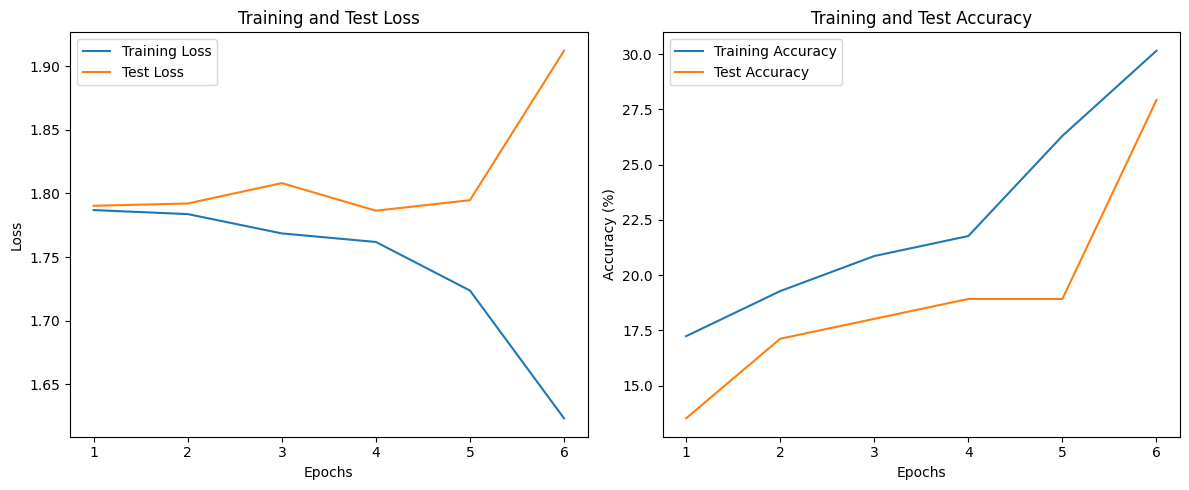

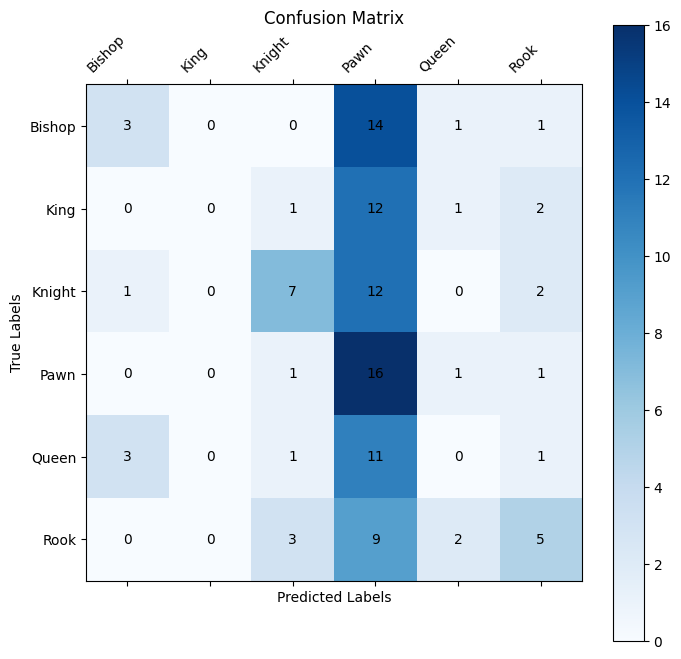

In [9]:
model = ConvNet2(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50)

6 capas convolutivas y dropout

Epoch 1, Training Loss: 1.7917577241148268, Training Accuracy: 19.047619047619047%
Epoch 1, Test Loss: 1.7875066314424788, Test Accuracy: 17.117117117117118%
Epoch 2, Training Loss: 1.782925797360284, Training Accuracy: 19.727891156462587%
Epoch 2, Test Loss: 1.7879085029874529, Test Accuracy: 17.117117117117118%
Epoch 3, Training Loss: 1.7792238976274217, Training Accuracy: 19.047619047619047%
Epoch 3, Test Loss: 1.7853679827281408, Test Accuracy: 21.62162162162162%
Epoch 4, Training Loss: 1.768399225814002, Training Accuracy: 16.780045351473923%
Epoch 4, Test Loss: 1.7736717292240687, Test Accuracy: 18.91891891891892%
Epoch 5, Training Loss: 1.7309153165136064, Training Accuracy: 22.22222222222222%
Epoch 5, Test Loss: 1.8213508129119873, Test Accuracy: 18.01801801801802%
Epoch 6, Training Loss: 1.7173975961548942, Training Accuracy: 21.541950113378686%
Epoch 6, Test Loss: 1.753984911101205, Test Accuracy: 18.91891891891892%
Epoch 7, Training Loss: 1.614207821232932, Training Accuracy

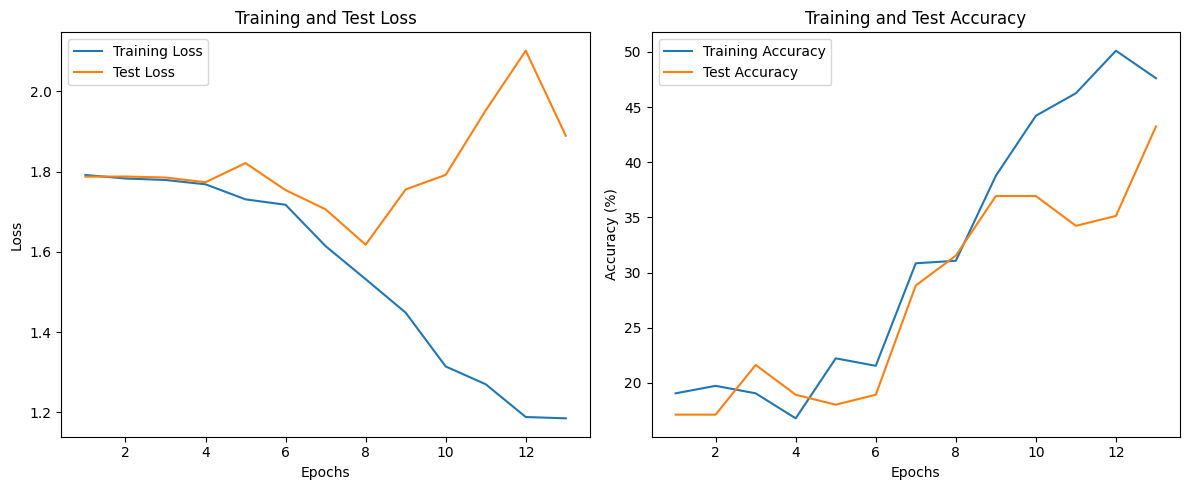

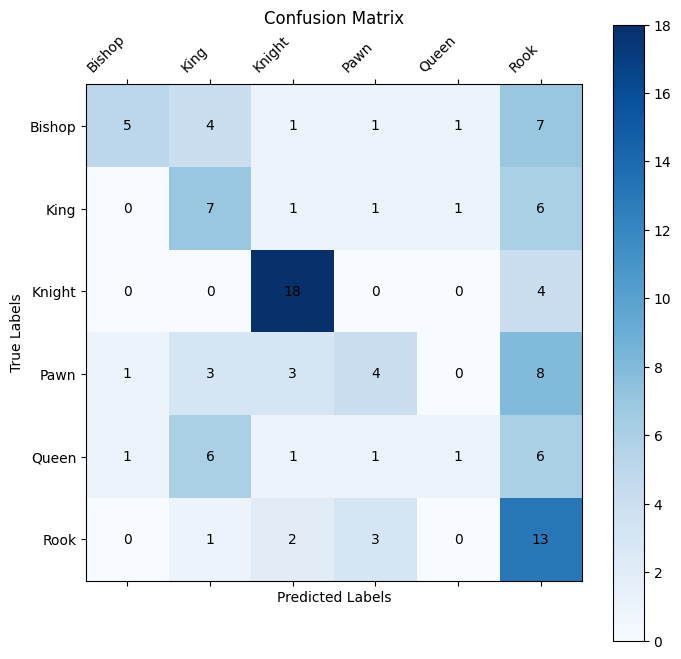

In [10]:
model = ConvNet3(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50)

Vamos a utilizar OpenCV para preprocesar las imágenes.

In [11]:
import cv2
import os
import numpy as np

def detect_edges_and_refine(image_path, save_processed_image=False, output_dir=None, fraction=1/2, grosor=1):
    """
    Aplica detección de bordes, engrosa las líneas detectadas, encuentra los contornos y la recorta según la fración indicada.
    
    Args:
        image_path (str): Ruta de la imagen a procesar.
        save_processed_image (bool): Si es True, guarda la imagen procesada.
        output_dir (str): Directorio donde guardar la imagen procesada si save_processed_image es True.
        fraction (float): Proporción de la imagen que se recorta.
    
    Returns:
        image (np.array): Imagen procesada con bordes engrosados y la mitad superior recortada.
    """
    if not os.path.exists(image_path.replace("\\", "/")):
        print(f"Error: La imagen {image_path.replace('\\', '/')} no existe.")
        return None

    image = cv2.imread(image_path.replace("\\", "/"))
    if image is None:
        print(f"Error: No se pudo cargar la imagen en {image_path.replace('\\', '/')}.\nPosiblemente esté dañada o el formato no es compatible.")
        return None

    image_resized = cv2.resize(image, (256, 256))
    gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    edges = cv2.Canny(blurred, threshold1=50, threshold2=200)

    kernel = np.ones((3, 3), np.uint8)
    thick_edges = cv2.dilate(edges, kernel, iterations=2)

    contours, _ = cv2.findContours(thick_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_image = np.zeros_like(image_resized)
    cv2.drawContours(contour_image, contours, -1, (255, 255, 255), grosor)

    height, _ = contour_image.shape[:2]
    if not (0 < fraction <= 1):
        raise ValueError("fraction debe estar en el rango (0, 1].")
    upper_fraction = contour_image[:int(height * fraction), :]

    if save_processed_image and output_dir:
        os.makedirs(output_dir, exist_ok=True)
        processed_image_path = os.path.join(output_dir, os.path.basename(image_path))
        
        cv2.imwrite(processed_image_path, upper_fraction)
    
    return upper_fraction


def process_dataset(input_dir, output_dir, fraction = 1/2, grosor=1):
    """
    Procesa un conjunto de imágenes en un directorio, aplica detección de bordes, engrosa las líneas, encuentra contornos y la recorta según la fracción indicada.
    
    Args:
        input_dir (str): Directorio de entrada con imágenes organizadas por clases.
        output_dir (str): Directorio donde guardar las imágenes procesadas.
        fraction (float): Proporción de la imagen que se recorta.
    """
    os.makedirs(output_dir, exist_ok=True)

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if os.path.isdir(class_path):
            output_class_path = os.path.join(output_dir, class_name)
            os.makedirs(output_class_path, exist_ok=True)

            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                try:
                    processed_image = detect_edges_and_refine(
                        image_path, save_processed_image=True, output_dir=output_class_path, fraction=fraction, grosor=grosor
                    )
                except Exception as e:
                    print(f"Error procesando {image_name}: {e}")

In [12]:
input_dataset_dir = "data/raw/Chess"

output_processed_dir = "data/processed/Chess-processed1"
process_dataset(input_dataset_dir, output_processed_dir, 1/2, 1)

output_processed_dir = "data/processed/Chess-processed2"
process_dataset(input_dataset_dir, output_processed_dir, 2/3, 2)

output_processed_dir = "data/processed/Chess-processed3"
process_dataset(input_dataset_dir, output_processed_dir, 2/3, 6)

output_processed_dir = "data/processed/Chess-processed4"
process_dataset(input_dataset_dir, output_processed_dir, 2/3, 10)

Error: No se pudo cargar la imagen en data/raw/Chess/Bishop/00000095.gif.
Posiblemente esté dañada o el formato no es compatible.
Error: No se pudo cargar la imagen en data/raw/Chess/Bishop/00000095.gif.
Posiblemente esté dañada o el formato no es compatible.
Error: No se pudo cargar la imagen en data/raw/Chess/Bishop/00000095.gif.
Posiblemente esté dañada o el formato no es compatible.
Error: No se pudo cargar la imagen en data/raw/Chess/Bishop/00000095.gif.
Posiblemente esté dañada o el formato no es compatible.


In [13]:
class ConvNet4(nn.Module):
    def __init__(self, classes):
        super(ConvNet4, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.dropout = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(512, len(classes))
        self.classes = classes
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x))) 
        x = self.pool(F.relu(self.conv4(x))) 
        #print(x.shape)
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x)) 
        x = self.dropout(x)
        x = self.fc2(x) 
        
        return x

class ConvNet5(nn.Module):
    def __init__(self, classes):
        super(ConvNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(1024 * 1*1, 2048)
        self.fc2 = nn.Linear(2048, len(classes))
        self.classes = classes

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        #print(x.shape)
        x = x.view(-1, 1024 * 1*1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [14]:
# Transformaciones avanzadas para el conjunto de entrenamiento
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=64, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.4, contrast=0.5, saturation=0.4, hue=0.4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [15]:
# Ruta de las imágenes
data_path = 'data/processed/Chess-processed1'

# Cargamos todas las imágenes de la carpeta con ImageFolder para ambos conjuntos
full_data = datasets.ImageFolder(root=data_path)

# Dividimos en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(full_data))  # 80% para entrenamiento
test_size = len(full_data) - train_size  # 20% para prueba
train_data, test_data = random_split(full_data, [train_size, test_size])

# Aplicamos las transformaciones a cada conjunto
train_data.dataset.transform = train_transform
test_data.dataset.transform = test_transform

# DataLoaders para el conjunto de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)


Epoch 1, Training Loss: 1.7868223530905587, Training Accuracy: 18.820861678004537%
Epoch 1, Test Loss: 1.7899839537484306, Test Accuracy: 18.01801801801802%
Epoch 2, Training Loss: 1.7836794129439764, Training Accuracy: 17.687074829931973%
Epoch 2, Test Loss: 1.792026128087725, Test Accuracy: 18.01801801801802%
Epoch 3, Training Loss: 1.7826666831970215, Training Accuracy: 19.501133786848072%
Epoch 3, Test Loss: 1.7951097318104334, Test Accuracy: 15.315315315315315%
Epoch 4, Training Loss: 1.7826279997825623, Training Accuracy: 16.099773242630384%
Epoch 4, Test Loss: 1.7965217999049596, Test Accuracy: 19.81981981981982%
Epoch 5, Training Loss: 1.7791717605931419, Training Accuracy: 19.27437641723356%
Epoch 5, Test Loss: 1.7976355382374354, Test Accuracy: 15.315315315315315%
Epoch 6, Training Loss: 1.7847928362233298, Training Accuracy: 18.367346938775512%
Epoch 6, Test Loss: 1.7906045062201363, Test Accuracy: 18.01801801801802%
Parada temprana activada. No hay mejora en la pérdida de v

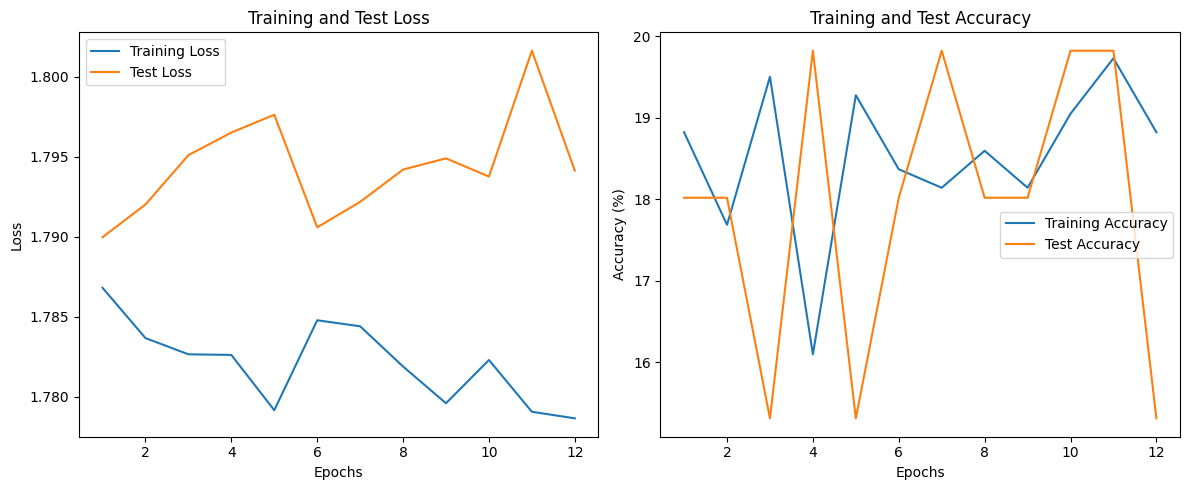

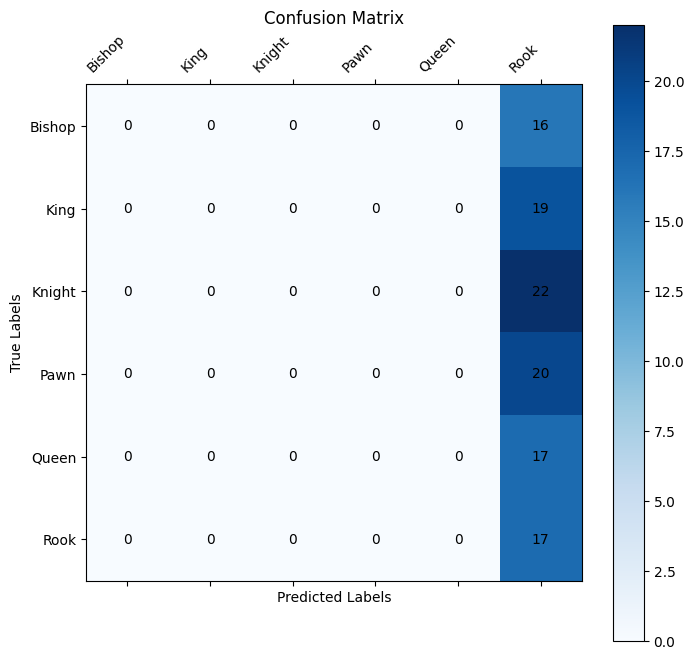

In [16]:
model = ConvNet4(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50, start_early_stop=10)

In [17]:
# Ruta de las imágenes
data_path = 'data/processed/Chess-processed2'

# Cargamos todas las imágenes de la carpeta con ImageFolder para ambos conjuntos
full_data = datasets.ImageFolder(root=data_path)

# Dividimos en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(full_data))  # 80% para entrenamiento
test_size = len(full_data) - train_size  # 20% para prueba
train_data, test_data = random_split(full_data, [train_size, test_size])

# Aplicamos las transformaciones a cada conjunto
train_data.dataset.transform = train_transform
test_data.dataset.transform = test_transform

# DataLoaders para el conjunto de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)


Epoch 1, Training Loss: 1.8148364680153983, Training Accuracy: 18.820861678004537%
Epoch 1, Test Loss: 1.7869584560394287, Test Accuracy: 15.315315315315315%
Epoch 2, Training Loss: 1.7871795381818498, Training Accuracy: 18.594104308390023%
Epoch 2, Test Loss: 1.7872464997427804, Test Accuracy: 20.72072072072072%
Epoch 3, Training Loss: 1.78542126928057, Training Accuracy: 17.913832199546484%
Epoch 3, Test Loss: 1.7859165157590593, Test Accuracy: 20.72072072072072%
Epoch 4, Training Loss: 1.7820672307695662, Training Accuracy: 17.913832199546484%
Epoch 4, Test Loss: 1.7869590520858765, Test Accuracy: 15.315315315315315%
Epoch 5, Training Loss: 1.7822968363761902, Training Accuracy: 20.18140589569161%
Epoch 5, Test Loss: 1.788001469203404, Test Accuracy: 15.315315315315315%
Epoch 6, Training Loss: 1.7741146683692932, Training Accuracy: 20.18140589569161%
Epoch 6, Test Loss: 1.770277806690761, Test Accuracy: 21.62162162162162%
Epoch 7, Training Loss: 1.694508365222386, Training Accuracy:

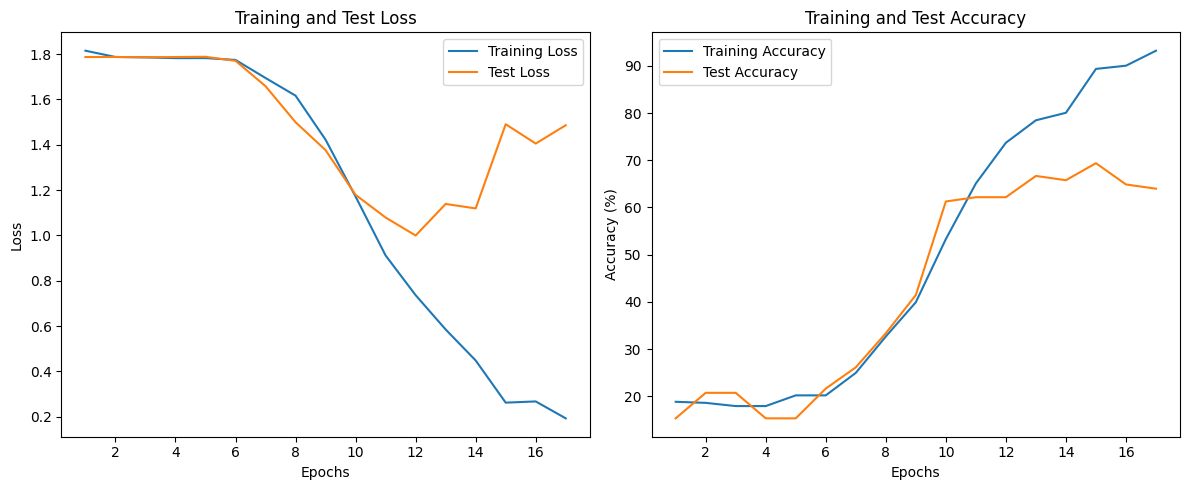

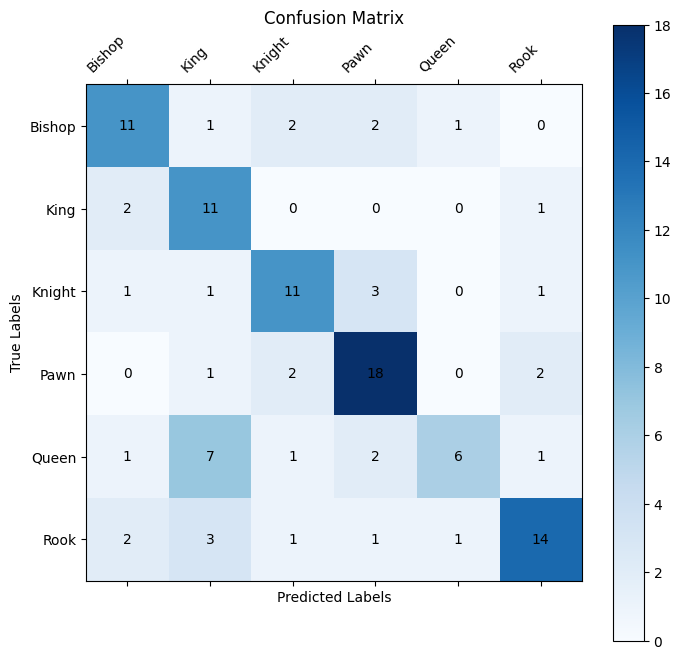

In [18]:
model = ConvNet4(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50, start_early_stop=10)

In [19]:
# Ruta de las imágenes
data_path = 'data/processed/Chess-processed3'

# Cargamos todas las imágenes de la carpeta con ImageFolder para ambos conjuntos
full_data = datasets.ImageFolder(root=data_path)

# Dividimos en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(full_data))  # 80% para entrenamiento
test_size = len(full_data) - train_size  # 20% para prueba
train_data, test_data = random_split(full_data, [train_size, test_size])

# Aplicamos las transformaciones a cada conjunto
train_data.dataset.transform = train_transform
test_data.dataset.transform = test_transform

# DataLoaders para el conjunto de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


Epoch 1, Training Loss: 1.7993804727281844, Training Accuracy: 14.285714285714286%
Epoch 1, Test Loss: 1.787323921918869, Test Accuracy: 19.81981981981982%
Epoch 2, Training Loss: 1.7909868189266749, Training Accuracy: 19.047619047619047%
Epoch 2, Test Loss: 1.7812194228172302, Test Accuracy: 19.81981981981982%
Epoch 3, Training Loss: 1.770040648324149, Training Accuracy: 19.501133786848072%
Epoch 3, Test Loss: 1.7085486948490143, Test Accuracy: 24.324324324324323%
Epoch 4, Training Loss: 1.6989686489105225, Training Accuracy: 24.489795918367346%
Epoch 4, Test Loss: 1.6310992240905762, Test Accuracy: 23.423423423423422%
Epoch 5, Training Loss: 1.6057665348052979, Training Accuracy: 32.6530612244898%
Epoch 5, Test Loss: 1.5408485233783722, Test Accuracy: 38.73873873873874%
Epoch 6, Training Loss: 1.4748581562723433, Training Accuracy: 40.136054421768705%
Epoch 6, Test Loss: 1.616095870733261, Test Accuracy: 29.72972972972973%
Epoch 7, Training Loss: 1.3436989784240723, Training Accuracy

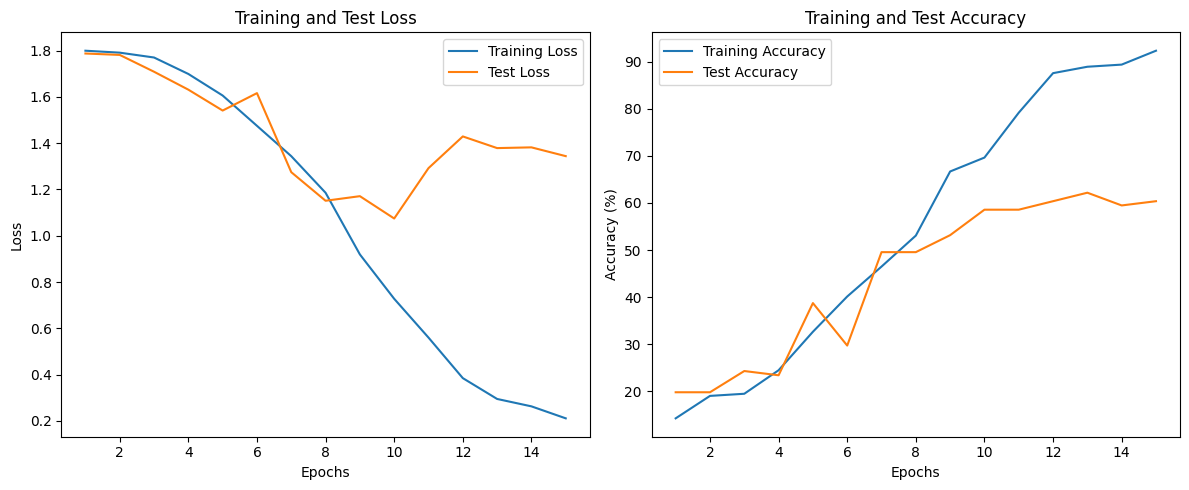

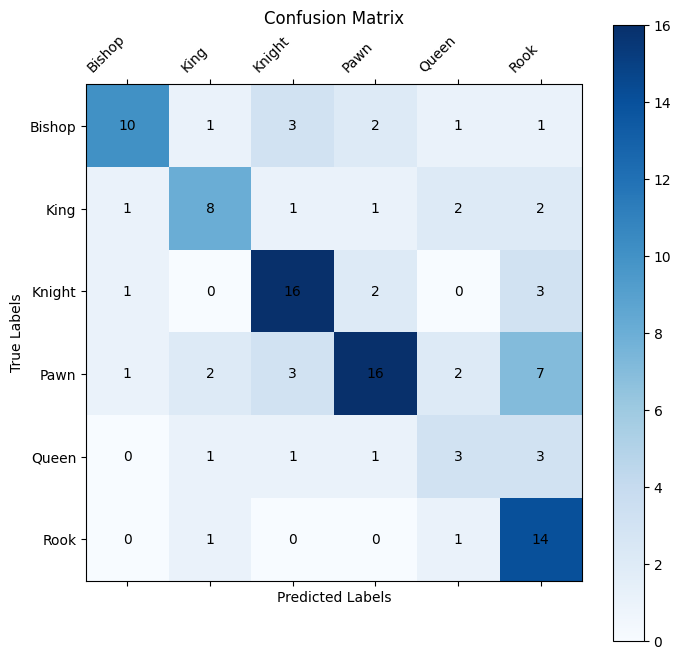

In [20]:
model = ConvNet4(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50, start_early_stop=10)

Epoch 1, Training Loss: 1.7925629956381661, Training Accuracy: 18.820861678004537%
Epoch 1, Test Loss: 1.7868394255638123, Test Accuracy: 14.414414414414415%
Epoch 2, Training Loss: 1.7859504222869873, Training Accuracy: 17.006802721088434%
Epoch 2, Test Loss: 1.7897281646728516, Test Accuracy: 14.414414414414415%
Epoch 3, Training Loss: 1.7855267865317208, Training Accuracy: 19.501133786848072%
Epoch 3, Test Loss: 1.7812408804893494, Test Accuracy: 14.414414414414415%
Epoch 4, Training Loss: 1.7832170554569788, Training Accuracy: 19.727891156462587%
Epoch 4, Test Loss: 1.7578082978725433, Test Accuracy: 20.72072072072072%
Epoch 5, Training Loss: 1.7449411494391305, Training Accuracy: 21.541950113378686%
Epoch 5, Test Loss: 1.6889809370040894, Test Accuracy: 23.423423423423422%
Epoch 6, Training Loss: 1.695421883038112, Training Accuracy: 26.077097505668934%
Epoch 6, Test Loss: 1.7285507917404175, Test Accuracy: 19.81981981981982%
Epoch 7, Training Loss: 1.642002352646419, Training Acc

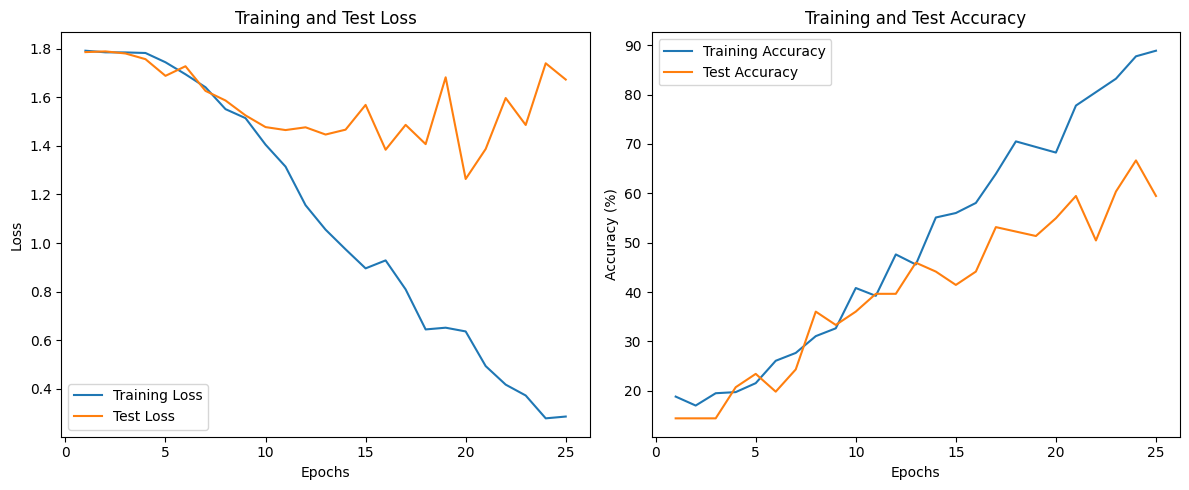

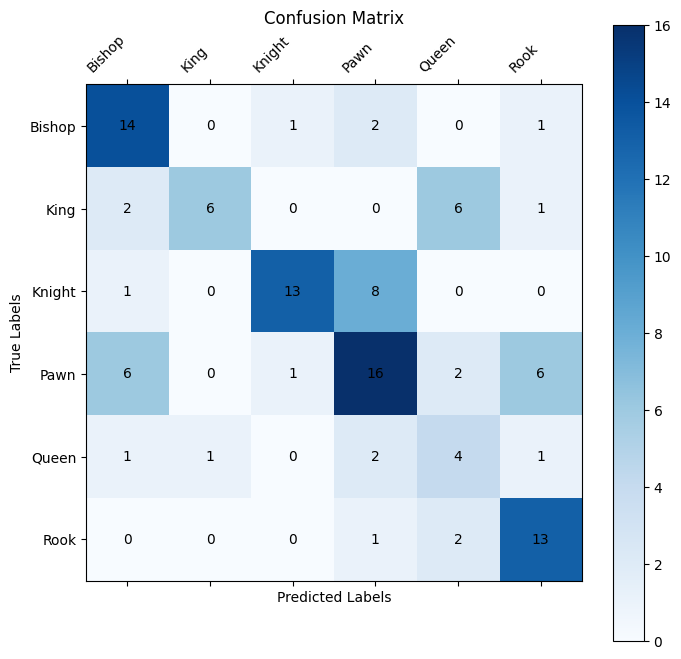

In [21]:
model = ConvNet5(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50, start_early_stop=10)

In [22]:
# Ruta de las imágenes
data_path = 'data/processed/Chess-processed4'

# Cargamos todas las imágenes de la carpeta con ImageFolder para ambos conjuntos
full_data = datasets.ImageFolder(root=data_path)

# Dividimos en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(full_data))  # 80% para entrenamiento
test_size = len(full_data) - train_size  # 20% para prueba
train_data, test_data = random_split(full_data, [train_size, test_size])

# Aplicamos las transformaciones a cada conjunto
train_data.dataset.transform = train_transform
test_data.dataset.transform = test_transform

# DataLoaders para el conjunto de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


Epoch 1, Training Loss: 1.8026322977883475, Training Accuracy: 19.047619047619047%
Epoch 1, Test Loss: 1.777908444404602, Test Accuracy: 12.612612612612613%
Epoch 2, Training Loss: 1.748326599597931, Training Accuracy: 21.31519274376417%
Epoch 2, Test Loss: 1.6808553040027618, Test Accuracy: 16.216216216216218%
Epoch 3, Training Loss: 1.6505614519119263, Training Accuracy: 29.25170068027211%
Epoch 3, Test Loss: 1.5954401195049286, Test Accuracy: 27.92792792792793%
Epoch 4, Training Loss: 1.5282695293426514, Training Accuracy: 38.095238095238095%
Epoch 4, Test Loss: 1.4687377214431763, Test Accuracy: 41.44144144144144%
Epoch 5, Training Loss: 1.3213411654744829, Training Accuracy: 48.07256235827664%
Epoch 5, Test Loss: 1.4044845700263977, Test Accuracy: 38.73873873873874%
Epoch 6, Training Loss: 1.120257271187646, Training Accuracy: 55.55555555555556%
Epoch 6, Test Loss: 1.3917043805122375, Test Accuracy: 48.648648648648646%
Epoch 7, Training Loss: 0.870803449835096, Training Accuracy: 

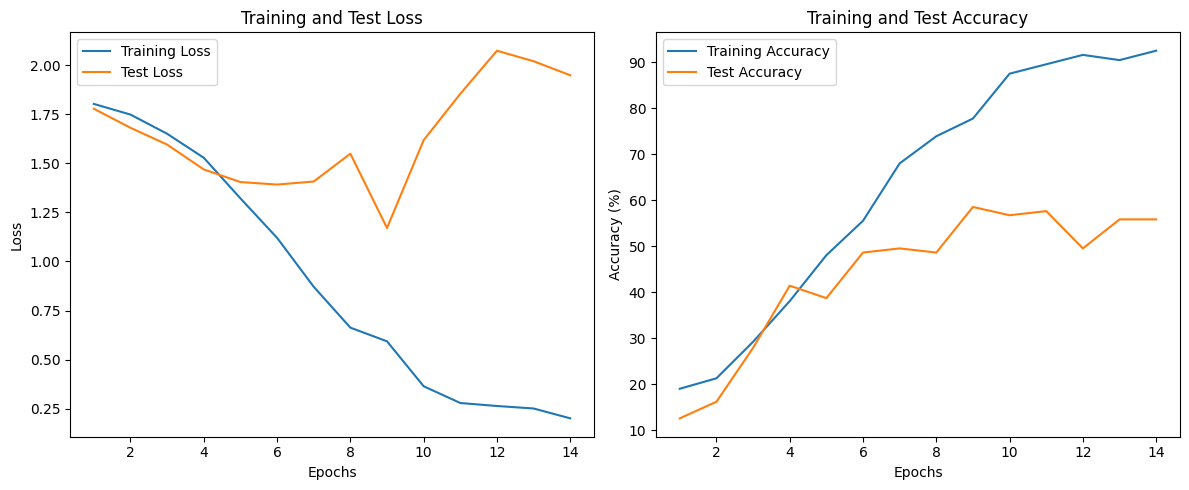

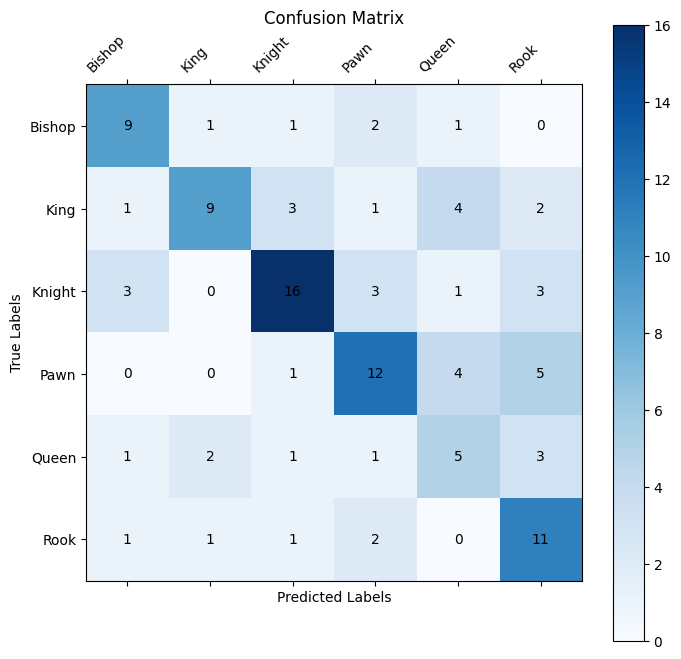

In [23]:
model = ConvNet4(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50, start_early_stop=10)

Epoch 1, Training Loss: 1.7881992033549718, Training Accuracy: 17.687074829931973%
Epoch 1, Test Loss: 1.7886101603507996, Test Accuracy: 14.414414414414415%
Epoch 2, Training Loss: 1.7860331109591894, Training Accuracy: 17.233560090702948%
Epoch 2, Test Loss: 1.7847725749015808, Test Accuracy: 14.414414414414415%
Epoch 3, Training Loss: 1.7804981640407018, Training Accuracy: 16.099773242630384%
Epoch 3, Test Loss: 1.767462968826294, Test Accuracy: 14.414414414414415%
Epoch 4, Training Loss: 1.7620972990989685, Training Accuracy: 19.501133786848072%
Epoch 4, Test Loss: 1.7585318982601166, Test Accuracy: 26.126126126126128%
Epoch 5, Training Loss: 1.6901166013308935, Training Accuracy: 26.984126984126984%
Epoch 5, Test Loss: 1.5906320810317993, Test Accuracy: 27.92792792792793%
Epoch 6, Training Loss: 1.6191498722348894, Training Accuracy: 29.705215419501133%
Epoch 6, Test Loss: 1.64188614487648, Test Accuracy: 31.53153153153153%
Epoch 7, Training Loss: 1.64453490291323, Training Accura

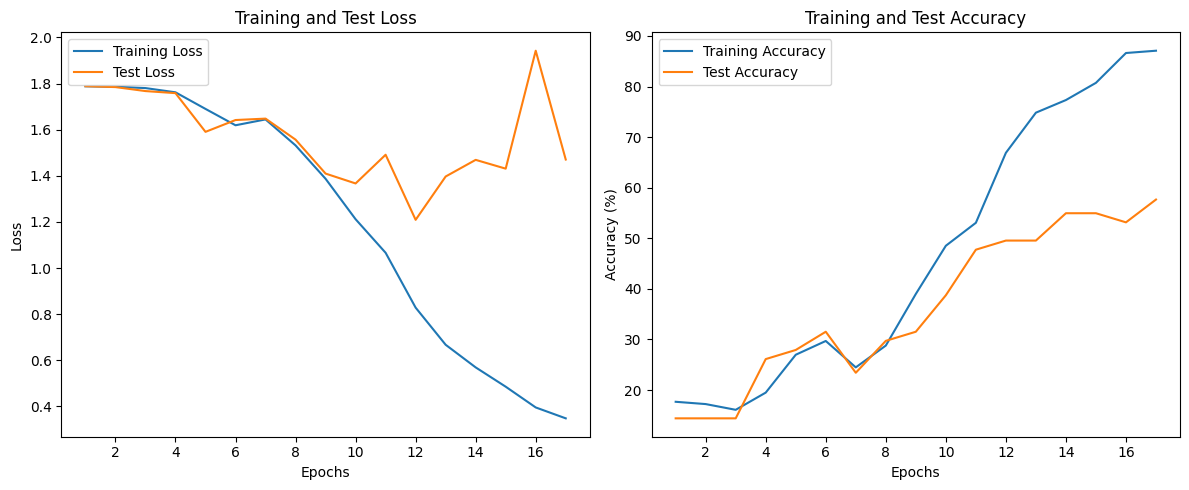

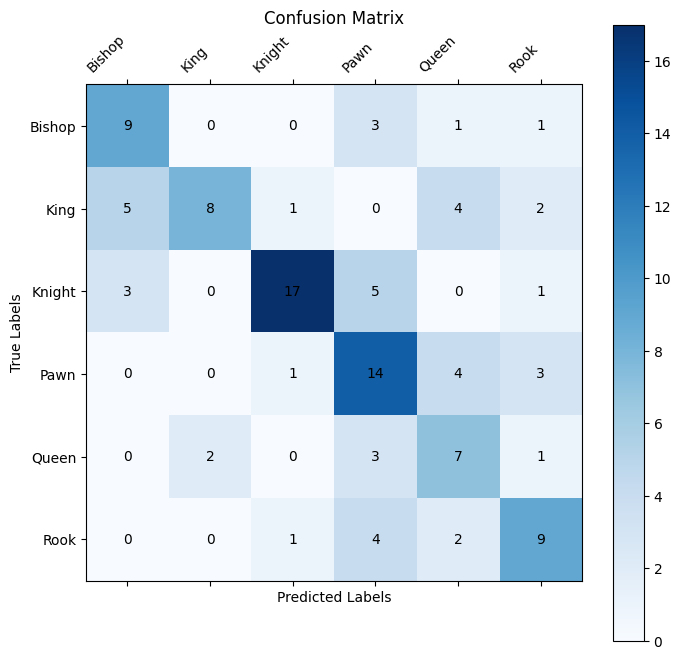

In [24]:
model = ConvNet5(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50, start_early_stop=10)